# Example queries for Demographics on COVID-19 Knowledge Graph
[Work in progress]

This notebook demonstrates how to run Cypher queries to get Demographics from the American Community Survey 5-year data at different levels of geographic granularity.

Demographics includes total population, and population by sex, race, ethnicity, and age group.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Get demographics by Zip code

In [4]:
zip_code = '90210'

##### Total population and sex

In [5]:
query = """
MATCH (p:PostalCode{name:$zip_code})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN p.name, d.totalPopulation, d.male, d.female
"""
df = graph.run(query, zip_code=zip_code).to_data_frame()
df.head()

,p.name,d.totalPopulation,d.male,d.female
0,90210,19909,9599,10310


##### Total population and race

In [6]:
query = """
MATCH (p:PostalCode{name:$zip_code})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN p.name, d.totalPopulation, d.white, d.blackOrAfricanAmerican, d.americanIndianAndAlaskaNative, 
       d.asian, d.nativeHawaiianAndOtherPacificIslander,d.otherRace, d.twoOrMoreRaces
"""
df = graph.run(query, zip_code=zip_code).to_data_frame()
df.fillna(0, inplace=True)
df.head()

,p.name,d.totalPopulation,d.white,d.blackOrAfricanAmerican,d.americanIndianAndAlaskaNative,d.asian,d.nativeHawaiianAndOtherPacificIslander,d.otherRace,d.twoOrMoreRaces
0,90210,19909,16911,0,21,1782,0,313,684


In [7]:
df['d.white'] + df['d.blackOrAfricanAmerican'] + df['d.americanIndianAndAlaskaNative'] + \
                df['d.asian'] + df['d.nativeHawaiianAndOtherPacificIslander'] + \
                df['d.otherRace'] + df['d.twoOrMoreRaces']

0    19711
dtype: int64

##### Total population and ethnicity
This example lists the total population and ethnicity for Zip codes with the place name Chula Vista (California)

In [8]:
place_name = 'Chula Vista'

query = """
MATCH (p:PostalCode{placeName:$place_name})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN p.name as `Zip code`, p.placeName, d.totalPopulation, d.hispanicOrLatino as `Hispanic or Latino`, 
       d.notHispanicOrLatino as `not Hispanic or Latino`
"""
df = graph.run(query, place_name=place_name).to_data_frame()
df.head()

,Zip code,p.placeName,d.totalPopulation,Hispanic or Latino,not Hispanic or Latino
0,91910,Chula Vista,74297,45307,28990
1,91911,Chula Vista,85365,61189,24176
2,91913,Chula Vista,53072,24788,28284
3,91914,Chula Vista,16357,7490,8867
4,91915,Chula Vista,31740,15287,16453


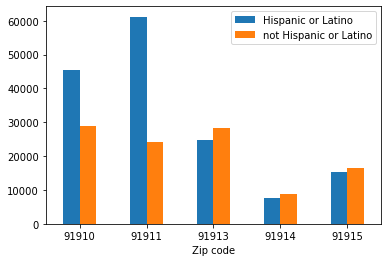

In [9]:
df.plot.bar(x='Zip code', y=['Hispanic or Latino', 'not Hispanic or Latino'], rot=0);

##### Total population and age groups

In [10]:
query = """
MATCH (p:PostalCode{name:$zip_code})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN p.name, d.totalPopulation, d.age0_4, d.age5_9, d.age10_14, d.age15_19, d.age20_24, 
       d.age25_34, d.age35_44, d.age45_54, d.age55_59, d.age60_64, d.age65_74, d.age75_84, d.age85_
"""
df = graph.run(query, zip_code=zip_code).to_data_frame()
df.head()

,p.name,d.totalPopulation,d.age0_4,d.age5_9,d.age10_14,d.age15_19,d.age20_24,d.age25_34,d.age35_44,d.age45_54,d.age55_59,d.age60_64,d.age65_74,d.age75_84,d.age85_
0,90210,19909,710,1014,1482,1066,519,1956,2292,3143,1282,1093,2562,1695,1095


Check: The sum of all age groups should add up to the total population.

In [11]:
df['d.age0_4'] + df['d.age5_9'] + df['d.age10_14'] + df['d.age15_19'] + df['d.age20_24'] + df['d.age25_34'] + \
                 df['d.age35_44'] + df['d.age45_54'] + df['d.age55_59'] + df['d.age60_64'] + df['d.age65_74'] + df['d.age75_84'] + \
                 df['d.age85_']

0    19909
dtype: int64

# Get demographics by US Census tract

##### Total population and race
This example shows how to aggregate tract-level data to the county (Admin2) level

In [12]:
county = 'San Diego County'

In [13]:
query = """
MATCH (a:Admin2{name: $county})<-[:IN]-(t:Tract)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN a.name AS County, sum(d.totalPopulation) as Total, sum(d.white) AS White, sum(d.blackOrAfricanAmerican) AS `Black or African American`, 
       sum(d.americanIndianAndAlaskaNative) AS `American Indian and Alaskan Native`, 
       sum(d.asian) AS Asian,
       sum(d.nativeHawaiianAndOtherPacificIslander) AS `Native Hawaiian and other Pacific Islander`, 
       sum(d.otherRace) AS `other Race`, sum(d.twoOrMoreRaces) AS `two or more Races`
"""
df = graph.run(query, county=county).to_data_frame()
df.fillna(0, inplace=True)
df.head(100)

,County,Total,White,Black or African American,American Indian and Alaskan Native,Asian,Native Hawaiian and other Pacific Islander,other Race,two or more Races
0,San Diego County,3302833,2335447,0,20980,390418,13903,205307,170366


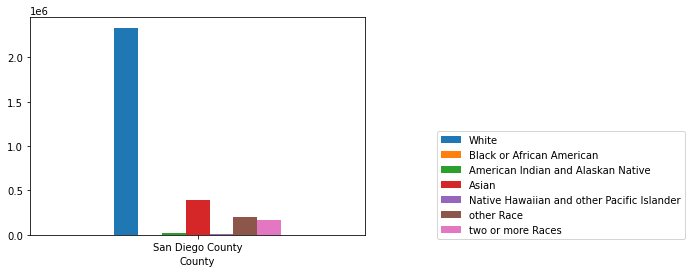

In [14]:
df.plot.bar(x='County', y=['White', 'Black or African American', 'American Indian and Alaskan Native', 'Asian',
                           'Native Hawaiian and other Pacific Islander', 'other Race', 'two or more Races'], rot=0).legend(bbox_to_anchor=(1.2, 0.5));

##### Total population and age group
This example shows how to aggregate tract-level data to the country level

In [15]:
query = """
MATCH (c:Country{iso:'US'})-[:IN]-(a1:Admin1)-[:IN]-(a2:Admin2)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN c.name AS Country, sum(d.totalPopulation) AS Total, 
       sum(d.age0_4) AS age0_4, sum(d.age5_9) AS age5_9, 
       sum(d.age10_14) AS age10_14, sum(d.age15_19) AS age15_19, sum(d.age20_24) AS age20_24, 
       sum(d.age25_34) AS age25_34, sum(d.age35_44) AS age35_44, sum(d.age45_54) AS age45_54, 
       sum(d.age55_59) AS age55_59, sum(d.age60_64) AS age60_64, sum(d.age65_74) as age65_74, 
       sum(d.age75_84) AS age75_84, sum(d.age85_) AS age85_
"""
df = graph.run(query).to_data_frame()
df.head()

,Country,Total,age0_4,age5_9,age10_14,age15_19,age20_24,age25_34,age35_44,age45_54,age55_59,age60_64,age65_74,age75_84,age85_
0,United States,322903030,19836850,20311494,20817419,21204226,22286970,44567976,40763210,42589573,21611374,19675357,28535419,14497679,6205483


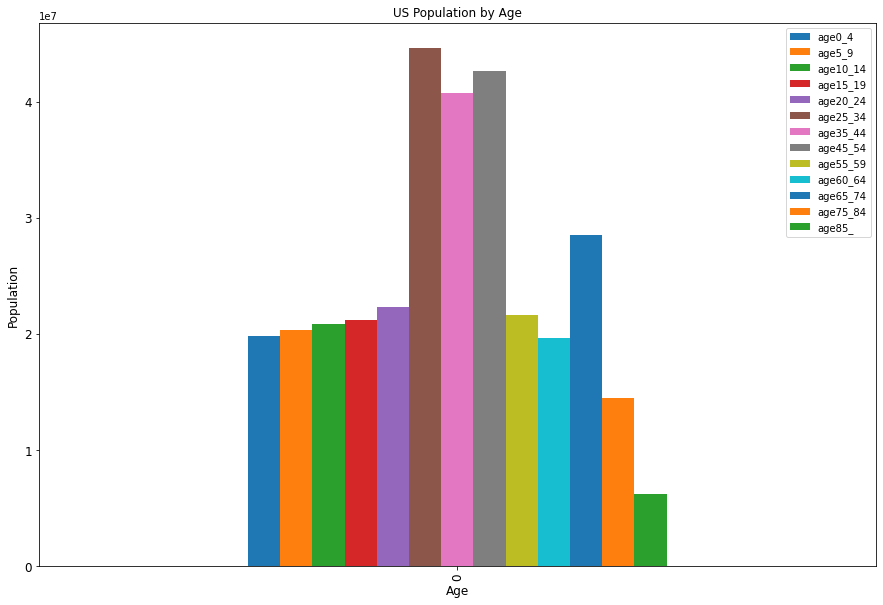

In [19]:
ax = df[['age0_4', 'age5_9', 'age10_14', 'age15_19','age20_24', 'age25_34', 'age35_44', 'age45_54', 'age55_59', \
         'age60_64', 'age65_74', 'age75_84', 'age85_']].plot(kind='bar', title ="US Population by Age", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Population", fontsize=12)
plt.show();